![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias & Google Drive

Para empezar carguemos esas librerias que nos hacen falta

In [87]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
import datetime
import random
import os

Incorporamos la carpeta de Google Drive para poder "guardar" nuestros modelos

1. Abrir barra lateral de Carpeta
2.  Hacer click en carpeta con logo de Google Drive


In [88]:
# Aquí iria el codigo para conectarse a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:**
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [89]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

In [90]:
print("Etiquetas de train:", y_train)


# Convertir los datos en arrays de una dimension (vectores) es una buena mejora en el dataset
y_train = y_train.ravel()
y_test = y_test.ravel()


print("Etiquetas de train (en vector):", y_train)


Etiquetas de train: [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
Etiquetas de train (en vector): [6 9 9 ... 9 1 1]


Obtenemos un array con todas las labels de CIFAR10

In [91]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000,)
Test: X=(10000, 32, 32, 3), y=(10000,)


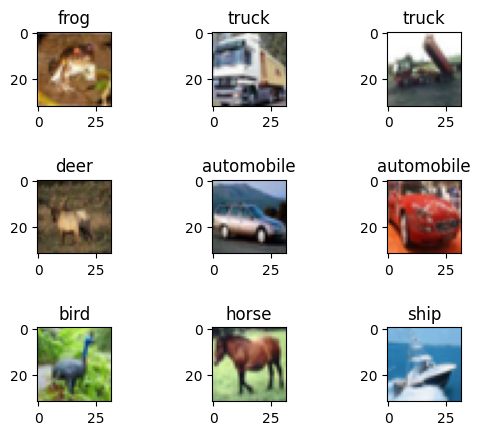

In [92]:
# Pintemos una muestra de las las imagenes del dataset MNIST

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [93]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]


Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [94]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)
Validation: X=(10000, 32, 32, 3), y=(10000,)


## Arquitectura de la Red Neuronal


In [95]:
# Creemos una red que será extracción de features basada en VGG16
model_vgg16 = vgg16.VGG16(include_top = False,
                          weights = 'imagenet',
                          input_shape = (32,32,3))

In [96]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [97]:
# Añadir un Flatten en la última capa
output = model_vgg16.layers[-1].output
output_layer=ks.layers.Flatten()(output)
final_vgg16 = Model(model_vgg16.input,output_layer)
final_vgg16.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [98]:
# Veamos como va lo de "congelar" capas de entrenamiento
final_vgg16.trainable

True

In [99]:
pd.set_option("max_colwidth", True)
layers = [(layer, layer.name, layer.trainable) for layer in final_vgg16.layers]
pd.DataFrame(layers, columns=("Layer","Layer Name","Is Trainable?"))

,Layer,Layer Name,Is Trainable?
0,<keras.src.engine.input_layer.InputLayer object at 0x7cf0ca86fd30>,input_4,True
1,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf0ca86d330>,block1_conv1,True
2,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf0b01c7cd0>,block1_conv2,True
3,<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7cf0523d0520>,block1_pool,True
4,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf0523d01f0>,block2_conv1,True
5,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf052346470>,block2_conv2,True
6,<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7cf11f2709a0>,block2_pool,True
7,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf0b01c5360>,block3_conv1,True
8,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf11f272050>,block3_conv2,True
9,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf11f272860>,block3_conv3,True


In [100]:
entrenable = False
for layer in final_vgg16.layers:
  if layer.name == "block3_conv1":
    entrenable = True
  layer.trainable = entrenable

In [101]:
layers = [(layer, layer.name, layer.trainable) for layer in final_vgg16.layers]
pd.DataFrame(layers, columns=("Layer","Layer Name","Is Trainable?"))

,Layer,Layer Name,Is Trainable?
0,<keras.src.engine.input_layer.InputLayer object at 0x7cf0ca86fd30>,input_4,False
1,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf0ca86d330>,block1_conv1,False
2,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf0b01c7cd0>,block1_conv2,False
3,<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7cf0523d0520>,block1_pool,False
4,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf0523d01f0>,block2_conv1,False
5,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf052346470>,block2_conv2,False
6,<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7cf11f2709a0>,block2_pool,False
7,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf0b01c5360>,block3_conv1,True
8,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf11f272050>,block3_conv2,True
9,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf11f272860>,block3_conv3,True


## Montar la red de clasificación

In [102]:
model_post_vgg = ks.Sequential()

model_post_vgg.add(final_vgg16)
model_post_vgg.add(Dense(512, activation='relu'))
model_post_vgg.add(BatchNormalization())
model_post_vgg.add(Dense(512, activation='relu'))
model_post_vgg.add(BatchNormalization())
model_post_vgg.add(Dropout(0.3))

model_post_vgg.add(Dense(10, activation='softmax'))

model_post_vgg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 512)               14714688  
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_6 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_7 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 512)              

## Definir Optimizador

In [103]:
new_adam = Adam(learning_rate=0.000001)

In [104]:
model_post_vgg.compile(loss='sparse_categorical_crossentropy', optimizer=new_adam, metrics=['accuracy'])

## Early Stopping

In [105]:
callback_loss = EarlyStopping(monitor='val_loss', patience=5)
callback_acc = EarlyStopping(monitor='val_acc', patience=5)

## Data Augmentation

## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [106]:
t = time.perf_counter()

In [107]:
history = model_post_vgg.fit(x=x_train, y=y_train, batch_size=512,     # bajamos el batch_size
                             epochs=100, callbacks=[callback_loss, callback_acc],
                             validation_data=(x_val, y_val))

Epoch 1/100
78/79 [============================>.] - ETA: 0s - loss: 3.0961 - accuracy: 0.1329

79/79 [==============================] - 16s 139ms/step - loss: 3.0954 - accuracy: 0.1330 - val_loss: 2.7091 - val_accuracy: 0.1644
Epoch 2/100
78/79 [============================>.] - ETA: 0s - loss: 2.6712 - accuracy: 0.2004

79/79 [==============================] - 10s 129ms/step - loss: 2.6709 - accuracy: 0.2005 - val_loss: 2.2527 - val_accuracy: 0.2657
Epoch 3/100
78/79 [============================>.] - ETA: 0s - loss: 2.3721 - accuracy: 0.2622

79/79 [==============================] - 11s 136ms/step - loss: 2.3716 - accuracy: 0.2621 - val_loss: 1.9820 - val_accuracy: 0.3492
Epoch 4/100
78/79 [============================>.] - ETA: 0s - loss: 2.1380 - accuracy: 0.3166

79/79 [==============================] - 10s 131ms/step - loss: 2.1377 - accuracy: 0.3167 - val_loss: 1.8092 - val_accuracy: 0.4049
Epoch 5/100
78/79 [============================>.] - ETA: 0s - loss: 1.9664 - accuracy: 0.3641

79/79 [==============================] - 11s 133ms/step - loss: 1.9665 - accuracy: 0.3640 - val_loss: 1.6634 - val_accuracy: 0.4468
Epoch 6/100
78/79 [============================>.] - ETA: 0s - loss: 1.8190 - accuracy: 0.4061

79/79 [==============================] - 10s 129ms/step - loss: 1.8188 - accuracy: 0.4062 - val_loss: 1.5552 - val_accuracy: 0.4834
Epoch 7/100
78/79 [============================>.] - ETA: 0s - loss: 1.7064 - accuracy: 0.4425

79/79 [==============================] - 10s 131ms/step - loss: 1.7059 - accuracy: 0.4427 - val_loss: 1.4682 - val_accuracy: 0.5173
Epoch 8/100
78/79 [============================>.] - ETA: 0s - loss: 1.6163 - accuracy: 0.4741

79/79 [==============================] - 10s 127ms/step - loss: 1.6162 - accuracy: 0.4742 - val_loss: 1.3960 - val_accuracy: 0.5424
Epoch 9/100
78/79 [============================>.] - ETA: 0s - loss: 1.5309 - accuracy: 0.4964

79/79 [==============================] - 10s 128ms/step - loss: 1.5308 - accuracy: 0.4964 - val_loss: 1.3347 - val_accuracy: 0.5612
Epoch 10/100
78/79 [============================>.] - ETA: 0s - loss: 1.4668 - accuracy: 0.5197

79/79 [==============================] - 10s 133ms/step - loss: 1.4671 - accuracy: 0.5196 - val_loss: 1.2872 - val_accuracy: 0.5760
Epoch 11/100
78/79 [============================>.] - ETA: 0s - loss: 1.4029 - accuracy: 0.5410

79/79 [==============================] - 10s 133ms/step - loss: 1.4025 - accuracy: 0.5411 - val_loss: 1.2408 - val_accuracy: 0.5910
Epoch 12/100
78/79 [============================>.] - ETA: 0s - loss: 1.3538 - accuracy: 0.5557

79/79 [==============================] - 10s 129ms/step - loss: 1.3538 - accuracy: 0.5556 - val_loss: 1.2025 - val_accuracy: 0.6029
Epoch 13/100
78/79 [============================>.] - ETA: 0s - loss: 1.3030 - accuracy: 0.5706

79/79 [==============================] - 10s 128ms/step - loss: 1.3036 - accuracy: 0.5704 - val_loss: 1.1677 - val_accuracy: 0.6132
Epoch 14/100
78/79 [============================>.] - ETA: 0s - loss: 1.2660 - accuracy: 0.5823

79/79 [==============================] - 10s 128ms/step - loss: 1.2666 - accuracy: 0.5821 - val_loss: 1.1380 - val_accuracy: 0.6231
Epoch 15/100
78/79 [============================>.] - ETA: 0s - loss: 1.2279 - accuracy: 0.5927

79/79 [==============================] - 10s 133ms/step - loss: 1.2276 - accuracy: 0.5928 - val_loss: 1.1156 - val_accuracy: 0.6300
Epoch 16/100
78/79 [============================>.] - ETA: 0s - loss: 1.1899 - accuracy: 0.6057

79/79 [==============================] - 10s 127ms/step - loss: 1.1899 - accuracy: 0.6057 - val_loss: 1.0875 - val_accuracy: 0.6405
Epoch 17/100
78/79 [============================>.] - ETA: 0s - loss: 1.1640 - accuracy: 0.6139

79/79 [==============================] - 10s 132ms/step - loss: 1.1641 - accuracy: 0.6139 - val_loss: 1.0678 - val_accuracy: 0.6466
Epoch 18/100
78/79 [============================>.] - ETA: 0s - loss: 1.1356 - accuracy: 0.6222

79/79 [==============================] - 10s 128ms/step - loss: 1.1356 - accuracy: 0.6222 - val_loss: 1.0446 - val_accuracy: 0.6536
Epoch 19/100
78/79 [============================>.] - ETA: 0s - loss: 1.1113 - accuracy: 0.6310

79/79 [==============================] - 10s 128ms/step - loss: 1.1117 - accuracy: 0.6309 - val_loss: 1.0263 - val_accuracy: 0.6589
Epoch 20/100
78/79 [============================>.] - ETA: 0s - loss: 1.0916 - accuracy: 0.6379

79/79 [==============================] - 11s 133ms/step - loss: 1.0918 - accuracy: 0.6378 - val_loss: 1.0105 - val_accuracy: 0.6640
Epoch 21/100
78/79 [============================>.] - ETA: 0s - loss: 1.0640 - accuracy: 0.6453

79/79 [==============================] - 10s 133ms/step - loss: 1.0640 - accuracy: 0.6453 - val_loss: 0.9939 - val_accuracy: 0.6678
Epoch 22/100
78/79 [============================>.] - ETA: 0s - loss: 1.0493 - accuracy: 0.6503

79/79 [==============================] - 11s 133ms/step - loss: 1.0497 - accuracy: 0.6503 - val_loss: 0.9795 - val_accuracy: 0.6728
Epoch 23/100
78/79 [============================>.] - ETA: 0s - loss: 1.0281 - accuracy: 0.6556

79/79 [==============================] - 11s 134ms/step - loss: 1.0284 - accuracy: 0.6556 - val_loss: 0.9669 - val_accuracy: 0.6785
Epoch 24/100
78/79 [============================>.] - ETA: 0s - loss: 1.0033 - accuracy: 0.6657

79/79 [==============================] - 11s 134ms/step - loss: 1.0032 - accuracy: 0.6657 - val_loss: 0.9540 - val_accuracy: 0.6794
Epoch 25/100
78/79 [============================>.] - ETA: 0s - loss: 0.9873 - accuracy: 0.6706

79/79 [==============================] - 10s 133ms/step - loss: 0.9876 - accuracy: 0.6705 - val_loss: 0.9428 - val_accuracy: 0.6841
Epoch 26/100
78/79 [============================>.] - ETA: 0s - loss: 0.9722 - accuracy: 0.6749

79/79 [==============================] - 10s 128ms/step - loss: 0.9721 - accuracy: 0.6751 - val_loss: 0.9321 - val_accuracy: 0.6897
Epoch 27/100
78/79 [============================>.] - ETA: 0s - loss: 0.9575 - accuracy: 0.6792

79/79 [==============================] - 10s 133ms/step - loss: 0.9578 - accuracy: 0.6791 - val_loss: 0.9217 - val_accuracy: 0.6922
Epoch 28/100
78/79 [============================>.] - ETA: 0s - loss: 0.9403 - accuracy: 0.6841

79/79 [==============================] - 10s 133ms/step - loss: 0.9401 - accuracy: 0.6842 - val_loss: 0.9108 - val_accuracy: 0.6966
Epoch 29/100
78/79 [============================>.] - ETA: 0s - loss: 0.9262 - accuracy: 0.6896

79/79 [==============================] - 10s 133ms/step - loss: 0.9261 - accuracy: 0.6897 - val_loss: 0.9038 - val_accuracy: 0.6998
Epoch 30/100
78/79 [============================>.] - ETA: 0s - loss: 0.9172 - accuracy: 0.6940

79/79 [==============================] - 10s 133ms/step - loss: 0.9168 - accuracy: 0.6942 - val_loss: 0.8939 - val_accuracy: 0.7037
Epoch 31/100
78/79 [============================>.] - ETA: 0s - loss: 0.9018 - accuracy: 0.6970

79/79 [==============================] - 10s 128ms/step - loss: 0.9020 - accuracy: 0.6969 - val_loss: 0.8852 - val_accuracy: 0.7054
Epoch 32/100
78/79 [============================>.] - ETA: 0s - loss: 0.8907 - accuracy: 0.7013

79/79 [==============================] - 10s 128ms/step - loss: 0.8907 - accuracy: 0.7014 - val_loss: 0.8769 - val_accuracy: 0.7084
Epoch 33/100
78/79 [============================>.] - ETA: 0s - loss: 0.8793 - accuracy: 0.7040

79/79 [==============================] - 10s 128ms/step - loss: 0.8795 - accuracy: 0.7039 - val_loss: 0.8707 - val_accuracy: 0.7106
Epoch 34/100
78/79 [============================>.] - ETA: 0s - loss: 0.8631 - accuracy: 0.7081

79/79 [==============================] - 11s 133ms/step - loss: 0.8630 - accuracy: 0.7080 - val_loss: 0.8670 - val_accuracy: 0.7107
Epoch 35/100
78/79 [============================>.] - ETA: 0s - loss: 0.8529 - accuracy: 0.7116

79/79 [==============================] - 10s 129ms/step - loss: 0.8530 - accuracy: 0.7116 - val_loss: 0.8549 - val_accuracy: 0.7153
Epoch 36/100
78/79 [============================>.] - ETA: 0s - loss: 0.8357 - accuracy: 0.7168

79/79 [==============================] - 10s 129ms/step - loss: 0.8355 - accuracy: 0.7168 - val_loss: 0.8478 - val_accuracy: 0.7165
Epoch 37/100
78/79 [============================>.] - ETA: 0s - loss: 0.8319 - accuracy: 0.7191

79/79 [==============================] - 10s 129ms/step - loss: 0.8318 - accuracy: 0.7191 - val_loss: 0.8401 - val_accuracy: 0.7199
Epoch 38/100
78/79 [============================>.] - ETA: 0s - loss: 0.8175 - accuracy: 0.7243

79/79 [==============================] - 11s 133ms/step - loss: 0.8174 - accuracy: 0.7244 - val_loss: 0.8354 - val_accuracy: 0.7227
Epoch 39/100
78/79 [============================>.] - ETA: 0s - loss: 0.8109 - accuracy: 0.7255

79/79 [==============================] - 10s 129ms/step - loss: 0.8106 - accuracy: 0.7256 - val_loss: 0.8282 - val_accuracy: 0.7241
Epoch 40/100
78/79 [============================>.] - ETA: 0s - loss: 0.7955 - accuracy: 0.7303

79/79 [==============================] - 10s 133ms/step - loss: 0.7954 - accuracy: 0.7304 - val_loss: 0.8240 - val_accuracy: 0.7247
Epoch 41/100
78/79 [============================>.] - ETA: 0s - loss: 0.7848 - accuracy: 0.7342

79/79 [==============================] - 10s 128ms/step - loss: 0.7847 - accuracy: 0.7342 - val_loss: 0.8172 - val_accuracy: 0.7271
Epoch 42/100
78/79 [============================>.] - ETA: 0s - loss: 0.7778 - accuracy: 0.7373

79/79 [==============================] - 10s 129ms/step - loss: 0.7781 - accuracy: 0.7370 - val_loss: 0.8104 - val_accuracy: 0.7293
Epoch 43/100
78/79 [============================>.] - ETA: 0s - loss: 0.7673 - accuracy: 0.7416

79/79 [==============================] - 11s 134ms/step - loss: 0.7674 - accuracy: 0.7416 - val_loss: 0.8072 - val_accuracy: 0.7316
Epoch 44/100
78/79 [============================>.] - ETA: 0s - loss: 0.7620 - accuracy: 0.7421

79/79 [==============================] - 10s 129ms/step - loss: 0.7622 - accuracy: 0.7420 - val_loss: 0.8027 - val_accuracy: 0.7323
Epoch 45/100
78/79 [============================>.] - ETA: 0s - loss: 0.7504 - accuracy: 0.7469

79/79 [==============================] - 11s 133ms/step - loss: 0.7505 - accuracy: 0.7470 - val_loss: 0.7977 - val_accuracy: 0.7347
Epoch 46/100
78/79 [============================>.] - ETA: 0s - loss: 0.7483 - accuracy: 0.7482

79/79 [==============================] - 10s 128ms/step - loss: 0.7484 - accuracy: 0.7481 - val_loss: 0.7898 - val_accuracy: 0.7371
Epoch 47/100
78/79 [============================>.] - ETA: 0s - loss: 0.7380 - accuracy: 0.7502

79/79 [==============================] - 11s 133ms/step - loss: 0.7378 - accuracy: 0.7503 - val_loss: 0.7871 - val_accuracy: 0.7382
Epoch 48/100
78/79 [============================>.] - ETA: 0s - loss: 0.7246 - accuracy: 0.7561

79/79 [==============================] - 10s 129ms/step - loss: 0.7242 - accuracy: 0.7562 - val_loss: 0.7833 - val_accuracy: 0.7389
Epoch 49/100
78/79 [============================>.] - ETA: 0s - loss: 0.7200 - accuracy: 0.7564

79/79 [==============================] - 10s 129ms/step - loss: 0.7199 - accuracy: 0.7564 - val_loss: 0.7781 - val_accuracy: 0.7410
Epoch 50/100
78/79 [============================>.] - ETA: 0s - loss: 0.7140 - accuracy: 0.7576

79/79 [==============================] - 11s 133ms/step - loss: 0.7139 - accuracy: 0.7576 - val_loss: 0.7776 - val_accuracy: 0.7409
Epoch 51/100
78/79 [============================>.] - ETA: 0s - loss: 0.7067 - accuracy: 0.7593

79/79 [==============================] - 10s 128ms/step - loss: 0.7067 - accuracy: 0.7592 - val_loss: 0.7708 - val_accuracy: 0.7425
Epoch 52/100
78/79 [============================>.] - ETA: 0s - loss: 0.6967 - accuracy: 0.7620

79/79 [==============================] - 10s 129ms/step - loss: 0.6968 - accuracy: 0.7620 - val_loss: 0.7666 - val_accuracy: 0.7455
Epoch 53/100
78/79 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.7667

79/79 [==============================] - 10s 129ms/step - loss: 0.6853 - accuracy: 0.7665 - val_loss: 0.7622 - val_accuracy: 0.7463
Epoch 54/100
78/79 [============================>.] - ETA: 0s - loss: 0.6836 - accuracy: 0.7679

79/79 [==============================] - 10s 133ms/step - loss: 0.6836 - accuracy: 0.7679 - val_loss: 0.7586 - val_accuracy: 0.7471
Epoch 55/100
78/79 [============================>.] - ETA: 0s - loss: 0.6728 - accuracy: 0.7717

79/79 [==============================] - 10s 133ms/step - loss: 0.6728 - accuracy: 0.7717 - val_loss: 0.7561 - val_accuracy: 0.7483
Epoch 56/100
78/79 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.7727

79/79 [==============================] - 10s 128ms/step - loss: 0.6702 - accuracy: 0.7727 - val_loss: 0.7524 - val_accuracy: 0.7483
Epoch 57/100
78/79 [============================>.] - ETA: 0s - loss: 0.6603 - accuracy: 0.7744

79/79 [==============================] - 10s 129ms/step - loss: 0.6603 - accuracy: 0.7745 - val_loss: 0.7493 - val_accuracy: 0.7510
Epoch 58/100
78/79 [============================>.] - ETA: 0s - loss: 0.6568 - accuracy: 0.7758

79/79 [==============================] - 10s 128ms/step - loss: 0.6565 - accuracy: 0.7759 - val_loss: 0.7459 - val_accuracy: 0.7516
Epoch 59/100
78/79 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.7766

79/79 [==============================] - 11s 134ms/step - loss: 0.6520 - accuracy: 0.7767 - val_loss: 0.7438 - val_accuracy: 0.7529
Epoch 60/100
78/79 [============================>.] - ETA: 0s - loss: 0.6408 - accuracy: 0.7833

79/79 [==============================] - 10s 128ms/step - loss: 0.6407 - accuracy: 0.7833 - val_loss: 0.7402 - val_accuracy: 0.7545
Epoch 61/100
78/79 [============================>.] - ETA: 0s - loss: 0.6343 - accuracy: 0.7837

79/79 [==============================] - 10s 133ms/step - loss: 0.6343 - accuracy: 0.7837 - val_loss: 0.7375 - val_accuracy: 0.7565
Epoch 62/100
78/79 [============================>.] - ETA: 0s - loss: 0.6316 - accuracy: 0.7852

79/79 [==============================] - 10s 129ms/step - loss: 0.6315 - accuracy: 0.7853 - val_loss: 0.7352 - val_accuracy: 0.7579
Epoch 63/100
78/79 [============================>.] - ETA: 0s - loss: 0.6187 - accuracy: 0.7902

79/79 [==============================] - 10s 128ms/step - loss: 0.6185 - accuracy: 0.7903 - val_loss: 0.7323 - val_accuracy: 0.7565
Epoch 64/100
78/79 [============================>.] - ETA: 0s - loss: 0.6146 - accuracy: 0.7890

79/79 [==============================] - 10s 129ms/step - loss: 0.6146 - accuracy: 0.7890 - val_loss: 0.7311 - val_accuracy: 0.7577
Epoch 65/100
78/79 [============================>.] - ETA: 0s - loss: 0.6113 - accuracy: 0.7928

79/79 [==============================] - 10s 128ms/step - loss: 0.6113 - accuracy: 0.7927 - val_loss: 0.7259 - val_accuracy: 0.7602
Epoch 66/100
78/79 [============================>.] - ETA: 0s - loss: 0.6004 - accuracy: 0.7951

79/79 [==============================] - 10s 129ms/step - loss: 0.6001 - accuracy: 0.7952 - val_loss: 0.7249 - val_accuracy: 0.7591
Epoch 67/100
78/79 [============================>.] - ETA: 0s - loss: 0.5995 - accuracy: 0.7938

79/79 [==============================] - 11s 134ms/step - loss: 0.5993 - accuracy: 0.7937 - val_loss: 0.7226 - val_accuracy: 0.7599
Epoch 68/100
78/79 [============================>.] - ETA: 0s - loss: 0.5938 - accuracy: 0.7963

79/79 [==============================] - 10s 129ms/step - loss: 0.5938 - accuracy: 0.7963 - val_loss: 0.7203 - val_accuracy: 0.7616
Epoch 69/100
78/79 [============================>.] - ETA: 0s - loss: 0.5855 - accuracy: 0.8009

79/79 [==============================] - 10s 133ms/step - loss: 0.5854 - accuracy: 0.8009 - val_loss: 0.7189 - val_accuracy: 0.7613
Epoch 70/100
78/79 [============================>.] - ETA: 0s - loss: 0.5802 - accuracy: 0.8024

79/79 [==============================] - 10s 133ms/step - loss: 0.5802 - accuracy: 0.8023 - val_loss: 0.7160 - val_accuracy: 0.7626
Epoch 71/100
78/79 [============================>.] - ETA: 0s - loss: 0.5738 - accuracy: 0.8024

79/79 [==============================] - 10s 128ms/step - loss: 0.5737 - accuracy: 0.8024 - val_loss: 0.7135 - val_accuracy: 0.7642
Epoch 72/100
78/79 [============================>.] - ETA: 0s - loss: 0.5696 - accuracy: 0.8068

79/79 [==============================] - 10s 133ms/step - loss: 0.5698 - accuracy: 0.8068 - val_loss: 0.7113 - val_accuracy: 0.7641
Epoch 73/100
78/79 [============================>.] - ETA: 0s - loss: 0.5611 - accuracy: 0.8057

79/79 [==============================] - 11s 133ms/step - loss: 0.5611 - accuracy: 0.8056 - val_loss: 0.7095 - val_accuracy: 0.7658
Epoch 74/100
78/79 [============================>.] - ETA: 0s - loss: 0.5610 - accuracy: 0.8074

79/79 [==============================] - 10s 128ms/step - loss: 0.5609 - accuracy: 0.8074 - val_loss: 0.7076 - val_accuracy: 0.7645
Epoch 75/100
78/79 [============================>.] - ETA: 0s - loss: 0.5547 - accuracy: 0.8096

79/79 [==============================] - 10s 128ms/step - loss: 0.5548 - accuracy: 0.8095 - val_loss: 0.7051 - val_accuracy: 0.7652
Epoch 76/100
78/79 [============================>.] - ETA: 0s - loss: 0.5439 - accuracy: 0.8128

79/79 [==============================] - 10s 128ms/step - loss: 0.5438 - accuracy: 0.8128 - val_loss: 0.7026 - val_accuracy: 0.7675
Epoch 77/100
78/79 [============================>.] - ETA: 0s - loss: 0.5433 - accuracy: 0.8132

79/79 [==============================] - 11s 134ms/step - loss: 0.5434 - accuracy: 0.8131 - val_loss: 0.7027 - val_accuracy: 0.7667
Epoch 78/100
78/79 [============================>.] - ETA: 0s - loss: 0.5425 - accuracy: 0.8137

79/79 [==============================] - 10s 129ms/step - loss: 0.5422 - accuracy: 0.8138 - val_loss: 0.7010 - val_accuracy: 0.7661
Epoch 79/100
78/79 [============================>.] - ETA: 0s - loss: 0.5311 - accuracy: 0.8180

79/79 [==============================] - 10s 129ms/step - loss: 0.5308 - accuracy: 0.8181 - val_loss: 0.6967 - val_accuracy: 0.7708
Epoch 80/100
78/79 [============================>.] - ETA: 0s - loss: 0.5260 - accuracy: 0.8189

79/79 [==============================] - 10s 128ms/step - loss: 0.5263 - accuracy: 0.8188 - val_loss: 0.6959 - val_accuracy: 0.7697
Epoch 81/100
78/79 [============================>.] - ETA: 0s - loss: 0.5192 - accuracy: 0.8201

79/79 [==============================] - 10s 129ms/step - loss: 0.5193 - accuracy: 0.8201 - val_loss: 0.6941 - val_accuracy: 0.7693
Epoch 82/100
78/79 [============================>.] - ETA: 0s - loss: 0.5209 - accuracy: 0.8212

79/79 [==============================] - 10s 129ms/step - loss: 0.5211 - accuracy: 0.8213 - val_loss: 0.6933 - val_accuracy: 0.7701
Epoch 83/100
78/79 [============================>.] - ETA: 0s - loss: 0.5131 - accuracy: 0.8240

79/79 [==============================] - 11s 134ms/step - loss: 0.5134 - accuracy: 0.8239 - val_loss: 0.6921 - val_accuracy: 0.7686
Epoch 84/100
78/79 [============================>.] - ETA: 0s - loss: 0.5073 - accuracy: 0.8268

79/79 [==============================] - 10s 132ms/step - loss: 0.5075 - accuracy: 0.8267 - val_loss: 0.6898 - val_accuracy: 0.7693
Epoch 85/100
78/79 [============================>.] - ETA: 0s - loss: 0.5040 - accuracy: 0.8278

79/79 [==============================] - 10s 133ms/step - loss: 0.5042 - accuracy: 0.8277 - val_loss: 0.6869 - val_accuracy: 0.7713
Epoch 86/100
78/79 [============================>.] - ETA: 0s - loss: 0.4980 - accuracy: 0.8299

79/79 [==============================] - 10s 133ms/step - loss: 0.4981 - accuracy: 0.8298 - val_loss: 0.6866 - val_accuracy: 0.7720
Epoch 87/100
78/79 [============================>.] - ETA: 0s - loss: 0.4946 - accuracy: 0.8305

79/79 [==============================] - 10s 133ms/step - loss: 0.4946 - accuracy: 0.8305 - val_loss: 0.6847 - val_accuracy: 0.7745
Epoch 88/100
78/79 [============================>.] - ETA: 0s - loss: 0.4900 - accuracy: 0.8318

79/79 [==============================] - 10s 133ms/step - loss: 0.4903 - accuracy: 0.8317 - val_loss: 0.6837 - val_accuracy: 0.7730
Epoch 89/100
78/79 [============================>.] - ETA: 0s - loss: 0.4837 - accuracy: 0.8364

79/79 [==============================] - 10s 133ms/step - loss: 0.4842 - accuracy: 0.8361 - val_loss: 0.6818 - val_accuracy: 0.7742
Epoch 90/100
78/79 [============================>.] - ETA: 0s - loss: 0.4790 - accuracy: 0.8373

79/79 [==============================] - 10s 132ms/step - loss: 0.4793 - accuracy: 0.8372 - val_loss: 0.6817 - val_accuracy: 0.7738
Epoch 91/100
78/79 [============================>.] - ETA: 0s - loss: 0.4746 - accuracy: 0.8377

79/79 [==============================] - 10s 129ms/step - loss: 0.4748 - accuracy: 0.8377 - val_loss: 0.6795 - val_accuracy: 0.7755
Epoch 92/100
78/79 [============================>.] - ETA: 0s - loss: 0.4745 - accuracy: 0.8390

79/79 [==============================] - 10s 128ms/step - loss: 0.4749 - accuracy: 0.8389 - val_loss: 0.6781 - val_accuracy: 0.7764
Epoch 93/100
78/79 [============================>.] - ETA: 0s - loss: 0.4680 - accuracy: 0.8410

79/79 [==============================] - 10s 129ms/step - loss: 0.4678 - accuracy: 0.8411 - val_loss: 0.6785 - val_accuracy: 0.7762
Epoch 94/100
78/79 [============================>.] - ETA: 0s - loss: 0.4641 - accuracy: 0.8410

79/79 [==============================] - 10s 133ms/step - loss: 0.4640 - accuracy: 0.8410 - val_loss: 0.6770 - val_accuracy: 0.7767
Epoch 95/100
78/79 [============================>.] - ETA: 0s - loss: 0.4622 - accuracy: 0.8433

79/79 [==============================] - 10s 132ms/step - loss: 0.4621 - accuracy: 0.8434 - val_loss: 0.6753 - val_accuracy: 0.7775
Epoch 96/100
78/79 [============================>.] - ETA: 0s - loss: 0.4541 - accuracy: 0.8452

79/79 [==============================] - 10s 128ms/step - loss: 0.4539 - accuracy: 0.8453 - val_loss: 0.6751 - val_accuracy: 0.7782
Epoch 97/100
78/79 [============================>.] - ETA: 0s - loss: 0.4511 - accuracy: 0.8468

79/79 [==============================] - 10s 129ms/step - loss: 0.4512 - accuracy: 0.8468 - val_loss: 0.6728 - val_accuracy: 0.7780
Epoch 98/100
78/79 [============================>.] - ETA: 0s - loss: 0.4459 - accuracy: 0.8476

79/79 [==============================] - 10s 128ms/step - loss: 0.4461 - accuracy: 0.8476 - val_loss: 0.6710 - val_accuracy: 0.7794
Epoch 99/100
78/79 [============================>.] - ETA: 0s - loss: 0.4394 - accuracy: 0.8509

79/79 [==============================] - 10s 129ms/step - loss: 0.4396 - accuracy: 0.8508 - val_loss: 0.6711 - val_accuracy: 0.7776
Epoch 100/100
78/79 [============================>.] - ETA: 0s - loss: 0.4342 - accuracy: 0.8514

79/79 [==============================] - 10s 128ms/step - loss: 0.4343 - accuracy: 0.8515 - val_loss: 0.6698 - val_accuracy: 0.7791


In [108]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:17:16.331637


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [109]:
_, acc = model_post_vgg.evaluate(x_test, y_test, verbose=0)
print('Modelo con Basic Transfer Learning > %.3f' % (acc * 100.0))

Modelo con Basic Transfer Learning > 77.610


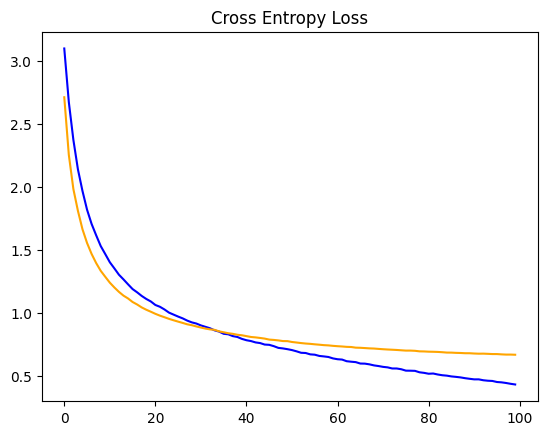

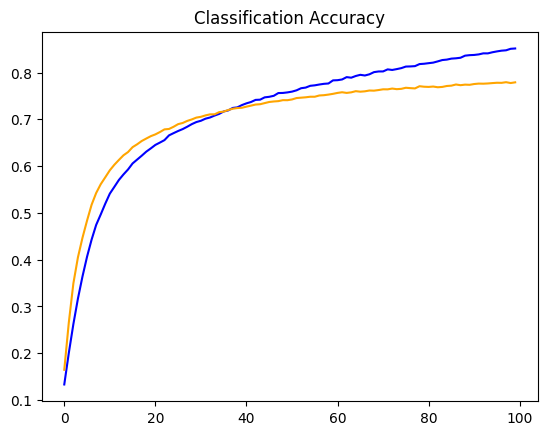

In [110]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [111]:
predictions = model_post_vgg.predict(x_test_scaled)

313/313 [==============================] - 2s 7ms/step


Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [112]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


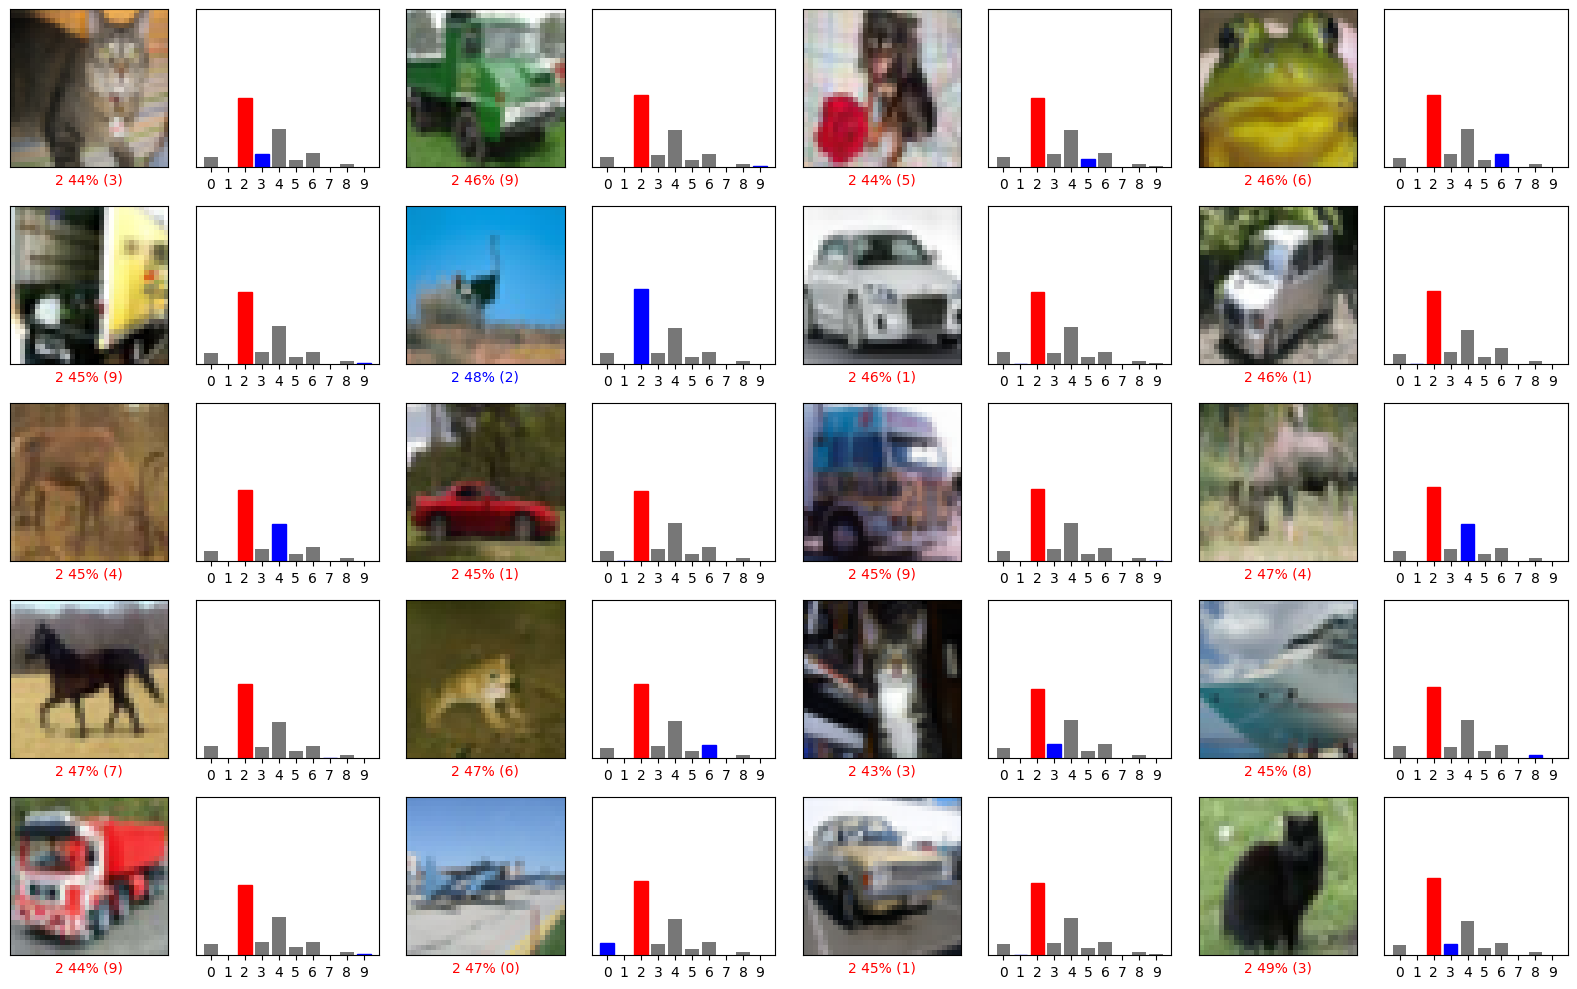

In [113]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 7. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [114]:
ruta_googledrive = "/content/drive/MyDrive/Colab Notebooks/Entregable 4/Modelos (1)"

model.save(ruta_googledrive+'cifar10_1_model.h5')

NameError: name 'model' is not defined